In [24]:
import numpy as np
import pandas as pd

df = pd.read_csv('spam.data', engine='pyarrow', sep=' ', header=None)
df.iloc[:, -1] = df.iloc[:, -1].astype(np.int8, errors='raise')

X = df.iloc[:, :-1].to_numpy()
Y = df.iloc[:, -1].to_numpy(dtype=np.int8)
print(df.shape)
print(X.shape)
print(Y.shape)

(4601, 58)
(4601, 57)
(4601,)


In [25]:
df.iloc[:, -1].unique()

array([1, 0], dtype=int64)

In [26]:
df.iloc[:, -1].value_counts()

57
0    2788
1    1813
Name: count, dtype: int64

In [27]:
df.iloc[:, -1].value_counts(normalize=True)

57
0    0.605955
1    0.394045
Name: proportion, dtype: float64

<Axes: ylabel='Frequency'>

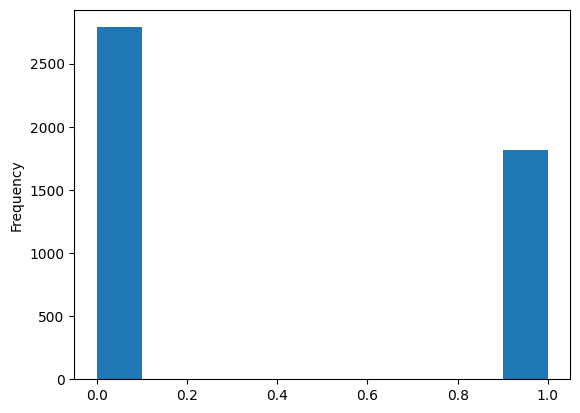

In [28]:
df.iloc[:, -1].plot.hist()

In [29]:
# df.describe().T

In [30]:
from sklearn.model_selection import train_test_split

n_splits = 5
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1/n_splits, random_state=SEED, stratify=Y)
print(X_train.shape)
print(y_train.shape)

(3680, 57)
(3680,)


In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC, LinearSVC

clf = make_pipeline(StandardScaler(), 
                    LinearSVC(dual='auto', random_state=42, tol=1e-6))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[530  28]
 [ 41 322]]


In [32]:
from numba import njit


def p_kernel(p: float):
    @njit
    def f(X1: np.ndarray, X2: np.ndarray):
        # (samples, features)
        # inn_prod: np.ndarray = np.einsum('sf->s', np.einsum('sf,sf->sf', X1, X2))
        # return np.power(1 + np.einsum('sf,ft->st', X1, np.einsum('sf->fs', X2)), p)
        # return np.power(1 + np.einsum('sf,ft->st', X1, X2.T), p)
        return (1 + X1 @ X2.T)**p
    return f

In [33]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import Normalizer, QuantileTransformer


def get_accuracy(p: float) -> np.ndarray:
    if p <= 1:
        classifier = SVC(kernel=p_kernel(p), tol=1e-6)
    else:
        classifier = make_pipeline(QuantileTransformer(), SVC(kernel=p_kernel(p), tol=1e-6))

    # classifier = SVC(kernel=p_kernel(p), tol=1e-6)
    kf = StratifiedKFold(n_splits=n_splits-1)
    return cross_val_score(classifier, X_train, y_train, cv=kf, error_score='raise')

In [34]:
from tqdm.notebook import tqdm

step = 0.1
for p in tqdm(np.arange(-3, 3+step, step=step)):
    scores = get_accuracy(p)
    print(f'{p=:.1f} - Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})')

  0%|          | 0/61 [00:00<?, ?it/s]

p=-3.0 - Accuracy: 0.606 (+/- 0.001)
p=-2.9 - Accuracy: 0.606 (+/- 0.001)
p=-2.8 - Accuracy: 0.606 (+/- 0.001)
p=-2.7 - Accuracy: 0.606 (+/- 0.001)
p=-2.6 - Accuracy: 0.606 (+/- 0.001)
p=-2.5 - Accuracy: 0.606 (+/- 0.001)
p=-2.4 - Accuracy: 0.606 (+/- 0.001)
p=-2.3 - Accuracy: 0.606 (+/- 0.001)
p=-2.2 - Accuracy: 0.606 (+/- 0.001)
p=-2.1 - Accuracy: 0.606 (+/- 0.001)
p=-2.0 - Accuracy: 0.606 (+/- 0.001)
p=-1.9 - Accuracy: 0.606 (+/- 0.001)
p=-1.8 - Accuracy: 0.606 (+/- 0.001)
p=-1.7 - Accuracy: 0.606 (+/- 0.001)
p=-1.6 - Accuracy: 0.606 (+/- 0.001)
p=-1.5 - Accuracy: 0.606 (+/- 0.001)
p=-1.4 - Accuracy: 0.606 (+/- 0.001)
p=-1.3 - Accuracy: 0.606 (+/- 0.001)
p=-1.2 - Accuracy: 0.606 (+/- 0.001)
p=-1.1 - Accuracy: 0.606 (+/- 0.001)
p=-1.0 - Accuracy: 0.606 (+/- 0.001)
p=-0.9 - Accuracy: 0.606 (+/- 0.001)
p=-0.8 - Accuracy: 0.606 (+/- 0.001)
p=-0.7 - Accuracy: 0.620 (+/- 0.025)
p=-0.6 - Accuracy: 0.683 (+/- 0.023)
p=-0.5 - Accuracy: 0.683 (+/- 0.030)
p=-0.4 - Accuracy: 0.663 (+/- 0.024)
p

In [35]:
%reset -f